<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 連接kaggle api
api_token = {"username":"victor830717","key":"e5ff0036288b15a13b2e2e4444e5051b"}
import json
import zipfile
import os

# 建資料夾 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
# !kaggle datasets download -d {kaggle資料集名稱} --force
!kaggle datasets download -d tongpython/cat-and-dog --force
 
!ls /kaggle

 99% 216M/218M [00:06<00:00, 27.2MB/s]
100% 218M/218M [00:06<00:00, 33.6MB/s]
cat-and-dog.zip


In [2]:
! unzip cat-and-dog.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training_set/training_s

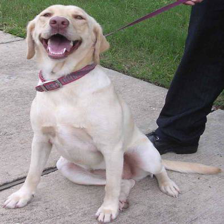

In [3]:
#glob用來查找文件
import glob
from PIL import Image
fs = glob.glob("/kaggle/training_set/training_set/dogs/*")
Image.open(fs[666]).resize((224, 224)).convert("RGB")
#調整大小

In [4]:
import pandas as pd
import glob
dog = glob.glob("/kaggle/training_set/training_set/dogs/dog.*")
cat = glob.glob("/kaggle/training_set/training_set/cats/cat.*")
datas = pd.DataFrame({
        "path":dog + cat,
        "ans":[0] * len(dog) + [1] * len(cat)
})
datas

,path,ans
0,/kaggle/training_set/training_set/dogs/dog.252...,0
1,/kaggle/training_set/training_set/dogs/dog.131...,0
2,/kaggle/training_set/training_set/dogs/dog.629...,0
3,/kaggle/training_set/training_set/dogs/dog.200...,0
4,/kaggle/training_set/training_set/dogs/dog.186...,0
...,...,...
8000,/kaggle/training_set/training_set/cats/cat.380...,1
8001,/kaggle/training_set/training_set/cats/cat.178...,1
8002,/kaggle/training_set/training_set/cats/cat.315...,1
8003,/kaggle/training_set/training_set/cats/cat.222...,1


In [10]:
# 在keras appliation偷模型
# include_top要不要當初的mlp
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=False, input_shape=(224, 224, 3), weights = 'imagenet')
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [16]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
inception_layers = inception.layers
#trainable：vgg不用來訓練，只用後面的mlp來訓練
for l in inception_layers:
    l.trainable = False

model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation="softmax"))
model.summary()
#這裡的dense的參數要選少，因為資料集不多

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 74,234,658
Trainable params: 52,431,874
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [18]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

x, y = np.array(datas["path"]), np.array(datas["ans"])
#batch多少張調整一次梯度下降
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    y_batch = y[idx]
    x_batch, x_batch_ori = [], []
    for p in x[idx]:
        img = Image.open(p).resize((224, 224)).convert("RGB")
        img_np = np.array(img) 
        img_np_pre = preprocess_input(img_np)
        x_batch.append(img_np_pre)
        x_batch_ori.append(img_np)
    return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [19]:
for i in range(20):
    print("-" * 15, i, "-" * 15)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Validate]:", result)

--------------- 0 ---------------
[Train]: [1.349400281906128, 0.4000000059604645]
[Validate]: [175.2077178955078, 0.5]
--------------- 1 ---------------
[Train]: [229.21829223632812, 0.25]
[Validate]: [1.577838659286499, 0.8999999761581421]
--------------- 2 ---------------
[Train]: [7.6575775146484375, 0.8500000238418579]
[Validate]: [34.80634307861328, 0.6000000238418579]
--------------- 3 ---------------
[Train]: [35.820926666259766, 0.6000000238418579]
[Validate]: [47.473533630371094, 0.44999998807907104]
--------------- 4 ---------------
[Train]: [32.467933654785156, 0.550000011920929]
[Validate]: [10.198870658874512, 0.699999988079071]
--------------- 5 ---------------
[Train]: [21.186046600341797, 0.5]
[Validate]: [0.0, 1.0]
--------------- 6 ---------------
[Train]: [0.0, 1.0]
[Validate]: [0.41626399755477905, 0.949999988079071]
--------------- 7 ---------------
[Train]: [0.0, 1.0]
[Validate]: [20.559951782226562, 0.8500000238418579]
--------------- 8 ---------------
[Train]: 

In [20]:
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 8s 92ms/step - loss: 1.3872 - accuracy: 0.9670


[1.3872443437576294, 0.9670000076293945]

63/63 [==============================] - 4s 71ms/step


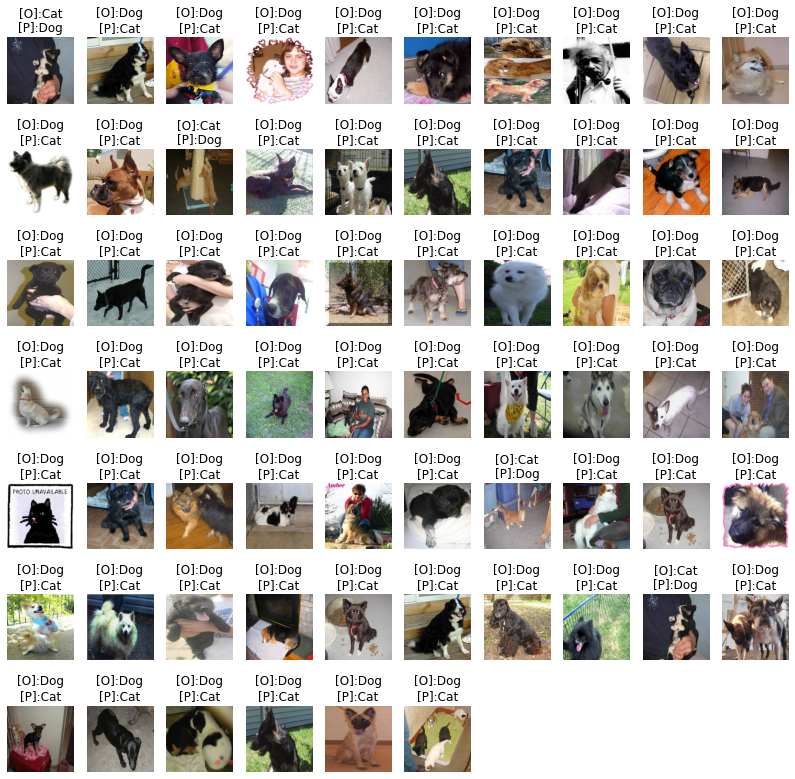

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#pre = model.predict_classes(x_batch) #tensorflow 撤銷此指令，改為下列這行
pre = np.argmax(model.predict(x_batch), axis=-1)
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 14))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])